## Variational approach

This approach consists of first generating a curve with a given topology, and forcing it to satisfy Newton's law of gravitation by minimizing its action.

## Code

The code of a $P$ periodic solution can be obtained by, for every collinear configuration, listing which one of the three bodies lays in the middle. For example, 132 would encode that body number 1 is in the middle in the first collinear configuration, then body number 3, and lastly body number 2. In the case of a choreography, the encoding will also display its permutation symmetry (e.g. 132 213 321). 

In [1]:
using FFTW
using LinearAlgebra
using Plots 
using OrdinaryDiffEq
using Optim

In [2]:
include("src/3body.jl"); include("src/TrigInt.jl"); include("src/IRK8.jl");

## Code inference

Given a discrete $P$ periodic curve (not necessarily a choreography), we want to have an algorithm that determines its code.

First, we define function $g$. It equals zero if and only if all three bodies are in a collinear configuration:

$$g(q) = (x_2-x_1)(y_3-y_2) - (x_3-x_2)(y_2-y_1)$$

and its derivative

$$g'(q) = (\dot x_2-\dot x_1)(y_3-y_2) + (x_2-x_1)(\dot y_3-\dot y_2) - (\dot x_3-\dot x_2)(y_2-y_1) - (x_3-x_2)(\dot y_2-\dot y_1)$$

In [3]:
g(q) = (q[2]-q[1])*(q[6]-q[5]) - (q[3]-q[2])*(q[5]-q[4])

dg(q, dq) = (dq[2]-dq[1])*(q[6]-q[5]) + (q[2]-q[1])*(dq[6]-dq[5]) - 
            (dq[3]-dq[2])*(q[5]-q[4]) - (q[3]-q[2])*(dq[5]-dq[4])

dg (generic function with 1 method)

Define function "middle" that, given a collinear configuration of the bodies, determines which body is in the middle by comparing the moduli of the vectors $q_{12}$, $q_{23}$, and $q_{31}$.

In [4]:
function middle(q)
    d12 = (q[2]-q[1])^2+(q[5]-q[4])^2
    d23 = (q[3]-q[2])^2+(q[6]-q[5])^2
    d31 = (q[1]-q[3])^2+(q[4]-q[6])^2
    im = argmax([d12, d23, d31])
    return [3, 1, 2][im]
end

middle (generic function with 1 method)

Our algorithm takes a discrete curve $qq = (q(t_0), q(t_1), \dots, q(t_N))$ and approximates the roots of $g$. To do so, it finds for which $t_j$ the following function changes its sign from negative to positive:

$$h(t) = \frac12 \frac{d}{dt}(g(q(t))^2) = g(q(t)) g'(q(t))$$

For each $t_j$ satisfying this condition, we approximate $q(t_j)$ via linear interpolation. We then evaluate $g^2(q_j)$, and if it is lower than a given threshold we can assume that $q_j$ corresponds to a collinear configuration.

Because we are working with discrete values of $x$ and $y$, their respective derivatives $\dot x_i$, $\dot y_i$ are obtained via trigonometric interpolation.

Finally, for each approximation of $q_j$ we find the body laying in the middle by using the function `middle` implemented above, and we create a list with the indices.

In [5]:
# Helper lambda
geq_zero(x) = x >= 0 ? 1 : 0

# Get code of a discrete curve qq
# q is considered to be a root of g if g(q)^2 is less than the threshold
function get_code(qq; threshold=1e-3)
    # Approximate the derivative of qq via trig int
    N = length(qq[1])
    DN = DiffMatrix(N)
    omega = 2*pi/N
    dqq = [omega*DN*xx for xx in qq]
    
    # Result
    s = []
    
    # Store previous h in order to find the change from - to +
    # Its initial value is q(t_N) since the curve is periodic
    qprev = get_q(qq, N)
    dprev = get_q(dqq, N)
    hprev = dg(qprev, dprev)*g(qprev)
    
    for i in 1:N
        qcurr = get_q(qq, i)
        dcurr = get_q(dqq, i)
        hcurr = dg(qcurr, dcurr)*g(qcurr)
        # If h goes from - to +, approximate q via linear interpolation
        if geq_zero(hprev) != geq_zero(hcurr)
            alpha = abs(hprev)/(abs(hprev)+abs(hcurr))
            qk = qcurr*alpha + qprev*(1-alpha)
            
            # Add qk to the code s if g(qk) is lower than the threshold
            if g(qk)^2 <= threshold
                push!(s, middle(qk))
            end
        end
        
        qprev = qcurr
        dprev = dcurr
        hprev = hcurr
    end
    return s
end

get_code (generic function with 1 method)

### Obtaining the code of the figure-eight
The figure-eight choreography has relative code (3, 1).

In [6]:
u0 = [4.174267456512568, -0.8888058233705901, 0.0, 1.7776116467411802, -4.174267456512568, -0.8888058233705901, 1.1102230246251565e-16, 0.2911946973117171, 0.683796458425381, -0.14559734865585836, -0.6837964584253811, -0.14559734865585874, 0.0]
T = 5.372134247663828
iter = 3

3

In [7]:
Tabs = iter*T
p = nothing
dt = 0.01
odef = ThreeBodyODEGlobalTR!

n = 999
m = Int64(round(Tabs/(n*dt)));

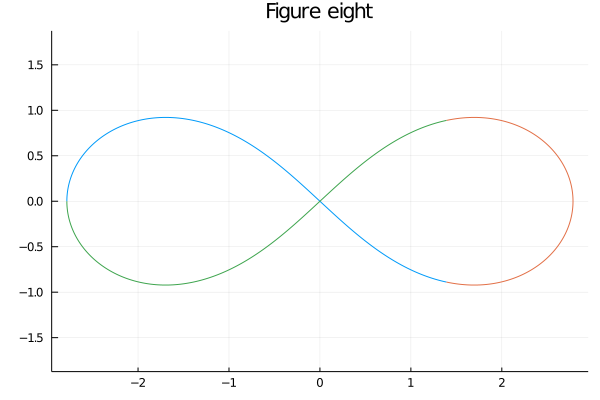

In [8]:
visualize(u0, odef, p, 0., T, n, m, "Figure eight")

Obtain the discrete curve

In [9]:
sol = IRK8(u0, 0., T*3, n, m, odef, p);
uu = sol.u;

Now we have to change formats. First to "pp" format, and second to "qq" format:

$p = (x_1, y_1, x_2, y_2, x_3, y_3)$, $pp = (p_1, \dots, p_n)$

$qq = (xx_1, xx_2, xx_3, yy_1, yy_2, yy_3)$, $xx_i = (x_i^1, \dots, x_i^n)$, and $x_i^j$ body $i$ at $t_j$.

In [10]:
pp = rel2absq.(to_p.(uu))
pp_indices = [1, 3, 5, 2, 4, 6]
qq = [[pp[j][pp_indices[i]] for j in 1:n] for i in 1:6];

We can see the absolute code of the figure-eight:

$3, 1 \rightarrow 2, 3 \rightarrow 1, 2$

In [11]:
print(get_code(qq))

Any[3, 1, 2, 3, 1, 2]

### Obtaining the code of the celtic knot

In [12]:
u0 = Float64[3.668247894, -2.35409389, 0.0, 4.708187788, -3.66824789, -2.35409389, 
        0.0, 0.253348151, 0.350877483, -0.12667408, -0.35087748, -0.12667408, 0.0]
T = 7.35504197
iter = 12;

In [13]:
Tabs = iter*T
p = nothing
dt = 0.01
odef = ThreeBodyODEGlobalTR!

n = 999
m = Int64(round(Tabs/(n*dt)));

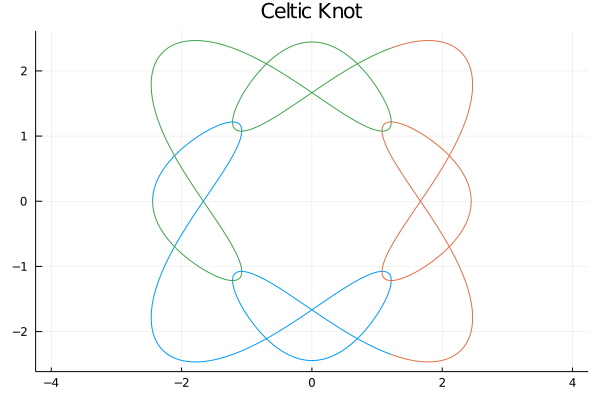

In [14]:
visualize(u0, odef, p, 0., Tabs/3, n, m, "Celtic Knot")

In [15]:
sol = IRK8(u0, 0., Tabs, n, m, odef, p)
uu = sol.u[1:end-1];

In [16]:
pp = rel2absq.(to_p.(uu))
pp_indices = [1, 3, 5, 2, 4, 6]
qq = [[pp[j][pp_indices[i]] for j in 1:n] for i in 1:6];

In [17]:
code = get_code(qq, threshold=1e-4)
print(code)

Any[3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2]

The Celtic Knot's four-way symmetry becomes apparent from its encoding

In [18]:
for i in 1:4
    print(code[6*(i-1)+1:6*i], "\n")
end

Any[3, 1, 2, 3, 1, 2]
Any[3, 1, 2, 3, 1, 2]
Any[3, 1, 2, 3, 1, 2]
Any[3, 1, 2, 3, 1, 2]


explain how it doesn't ensure that we will get a curve with the desired encoding

## Curve generation

Kodeketa bat hartuta kurba $P$ periodiko bat lortzeko (ez du zertan ekuazio diferentzialen soluzio izan), modu sinplea ondorengoa da: 

$s="s_1 s_2 \dots s_k"$ kodeketa dugu, non $s_i$ den $i$ garren konfigurazio kolinealean erdian dagoen gorputza.

$P$ finkaturik $k$ une diskretutan gorputzen posizioak zehaztuko ditugu. $i = 1, \dots, k$ balioetarako honakoak:

\begin{align}
    t_i &= P\frac{(i-1)}{k} \\
	x_{s_i} (t_i) &= 0 \\
	y_{s_i} (t_i) &= 0 \\
	x_{(s_i mod 3) + 1} (t_i) &= cos(\frac{2\pi}{k}(i-1)) \\
	y_{(s_i mod 3) + 1} (t_i) &= sin(\frac{2\pi}{k}(i-1)) \\
	x_{(s_i+1 mod 3) + 1} (t_i) &= -cos(\frac{2\pi}{k}(i-1)) \\
	y_{(s_i+1 mod 3) + 1} (t_i) &= -sin(\frac{2\pi}{k}(i-1)) 
\end{align} 

Koreografia izateko beste baldintza bat behar dugu, hiru gorputzek permutatu behar dute.

Honetarako, $P$ periodoaren herenean, $T$, puntuak generatuko ditugu, eta hauek permutatuz periodo osorako lortuko dugu. Behin hau eginik interpolazio trigonometrikoa erabiliz gero permutazio simetria mantenduko da, $x_i(t) = x_j(t+T((i-j) mod 3))$.

Ez daukat honen frogarik baina interpolazio trigonometrikoaren simetriagatik dela pentsatzen dut.

## Curve generation
Given a relative code $s = \langle s_1, \dots, s_k\rangle$, we want to algorithmically generate a $P$ periodic choreography with such a relative code.

First, we generate $k$ discrete uniformly-distributed points of the curve, where each point $q(t_i)$ is a collinear configuration with body $s_i$ is in the middle and the whole thing is rotated by $(i-1) \beta$, for some $\beta \in \mathbb{R}$.

So, we have the equations

\begin{align}
    t_i &= P\frac{(i-1)}{k} \\
	x_{s_i} (t_i) &= 0 \\
	y_{s_i} (t_i) &= 0 \\
	x_{(s_i mod 3) + 1} (t_i) &= cos(\frac{2\pi}{k}(i-1)) \\
	y_{(s_i mod 3) + 1} (t_i) &= sin(\frac{2\pi}{k}(i-1)) \\
	x_{(s_i+1 mod 3) + 1} (t_i) &= -cos(\frac{2\pi}{k}(i-1)) \\
	y_{(s_i+1 mod 3) + 1} (t_i) &= -sin(\frac{2\pi}{k}(i-1)) 
\end{align} 

$qq = (xx_1, xx_2, xx_3, yy_1, yy_2, yy_3)$

In [19]:
function generate_points(s, P; b=3)
    k = length(s)
    beta = 2pi/b
    
    tt = [P * (i-1) / k for i in 1:k]
    qq = [Array{Float64}(undef, k) for i in 1:6]
    
    for i in 1:k
        qq[s[i]][i] = 0
        qq[s[i] + 3][i] = 0
        qq[s[i]%3 + 1][i] = cos(beta*(i-1))
        qq[s[i]%3 + 4][i] = sin(beta*(i-1))
        qq[(s[i]+1)%3 + 1][i] = -cos(beta*(i-1))
        qq[(s[i]+1)%3 + 4][i] = -sin(beta*(i-1))
    end
    
    return qq, tt
end

generate_points (generic function with 1 method)

In order to generate a choreography, we need the curve to have permutation symmetry
$$
1 \rightarrow 2 \rightarrow 3 \rightarrow 1 (1)
$$

First, we generate $k$ points with code $s$ using `generate_points`. These points correspond to the relative period $T$, which is a third of the absolute period $P$. Now, we take the points generated and apply permutation (1) shown above to generate the rest of the points.

Once we have all these points, we can generate a curve with $N$ points using trigonometric interpolation. Because of the symmetry of trigonometric interpolation, permutation symmetry is satisfied, $x_i(t) = x_j(t+T((i-j) mod 3))$.

In [20]:
function generate_choreography(s, T, N)
    k = length(s)
    if N % 2 != k % 2
        N += 1
    end
    
    # Generate the points for [0, T)
    qq3, tt3 = generate_points(s, T)
    
    # Get the rest of the points by permuting qq3
    qq = [Array{Float64}(undef, k*3) for _ in 1:6]
    tt = Array{Float64}(undef, k*3)
    for i in 1:3
        qq_p = perm(qq3, 1-i)
        for j in 1:6
            @. qq[j][k*(i-1)+1:k*i] = qq_p[j]
        end
        @. tt[k*(i-1)+1:k*i] = tt3*i
    end
    
    # Get N points via trigonometric interpolation
    ta = 0.
    tb = T # T*3??

    QQ = [Array{Float64}(undef, N) for _ in 1:6]
    TT = Array{Float64}(undef, N)

    for j in 1:6
        xx = qq[j]
        (_,_,hf_t) = FourierCoeffs(tt,xx)
        (TT,XX) = FourierEval(ta,tb,hf_t,N)
        @. QQ[j] = XX
    end

    return QQ, TT
end

# permute q n times.
function perm(q, n)
    n = -n
    indices = [[1, 2, 3, 4, 5, 6],
               [2, 3, 1, 5, 6, 4],
               [3, 1, 2, 6, 4, 5]]
    return [q[i] for i in indices[mod(n, 3) + 1]]
end

perm (generic function with 1 method)

In [21]:
s = [3,1,2]
T = 7.0
N = 999
qq, tt = generate_choreography(s, T, N);

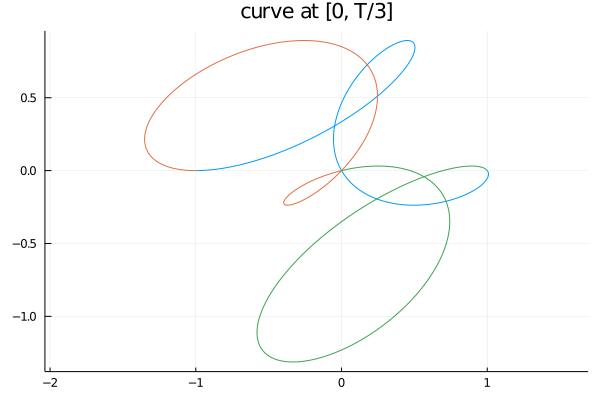

In [22]:
K = div(length(qq[1]), 3)+1
pl = plot(aspect_ratio=1, legend=false, title="curve at [0, T/3]")
plot!(qq[1][1:K],qq[4][1:K])
plot!(qq[2][1:K],qq[5][1:K])
plot!(qq[3][1:K],qq[6][1:K])
display(pl)

In [23]:
print(get_code(qq))

Any[3, 1, 2, 2, 3, 1, 1, 2, 3]

Center of mass always stays at the origin

In [24]:
mx = qq[1]+qq[2]+qq[3]
my = qq[4]+qq[5]+qq[6]

norm(mx), norm(my)

(5.784121785489543e-15, 4.634954482626918e-15)

There are no collisions when $|s| > 2$.

In [25]:
K = div(length(qq[1]), 3)+1

diff1 = (qq[1]-qq[2]).^2+(qq[4]-qq[5]).^2
diff2 = (qq[2]-qq[3]).^2+(qq[5]-qq[6]).^2
diff3 = (qq[3]-qq[1]).^2+(qq[6]-qq[4]).^2

min(diff1..., diff2..., diff3...)

0.010094400458936127

# Minimizing the action of the curves generated

Given a code $s$, our main goal is to generate a curve with such a code that is a solution to Newton's differential equations. So far we have been generating curves with the desired code, but they are not solutions to the differential equations. Therefore, we will minimize a functional called action.

## Action functional
The potential and kinetic energy of a system are the following:
\begin{align*}
	T(\dot x, \dot y) &= \frac 12 \sum_{i=1}^3 (\dot x_i (t)^2 + \dot y_i (t)^2) \\
	V(x,	 y) &= \sum_{1\leq i < j \leq 3} ((x_i(t) - x_j(t))^2 + (y_i(t) - y_j(t))^2)^{-\frac12}
\end{align*}

The action functional for a $P$ periodic curve is defined as:
$$
A(x, y; P) = \int_{0}^P (T(\dot x(t), \dot y(t)) +  V(x(t), y(t))) dt
$$

The action of a choreography is just $3 A(x, y; T)$ because of its permutation symmetry.

Hamilton's principle implies that for a given curve if $\nabla A = 0$, then it is a solution to Newton's differential equations.

## Computing the action of a dicrete curve

Since we are dealing with periodic curves, uniform discretization is as good as any other. 

$$
\tilde A_N(x, y; P) = 3\sum_{j=1}^{\frac N3} (T(\dot x(t_j), \dot y(t_j)) +  V(x(t_j), y(t_j)))
$$

Let $N = 3M$, we will use the following notation for the discretized variables:

$$
X = (x_1, \dots, x_{N}), \quad 
Y = ( y_1, \dots, y_{N}), \quad 
\dot X = (\dot x_1, \dots, \dot x_N), \quad 
\dot Y = (\dot y_1, \dots, \dot y_N).
$$

We will redefine the action for discrete inputs:

$$
\hat A_M (X,Y; P) = 3\sum_{j=1}^{M} (T_j(\dot X, \dot Y) + V_{j}(X, Y)), 
$$


$$
\begin{pmatrix} \dot x_1 \\ \dots \\ \dot x_N \\ \end{pmatrix}
= \omega \, D_N\,
\begin{pmatrix} x_1 \\ \dots \\ x_N \\ \end{pmatrix}, \quad
\begin{pmatrix} \dot y_1 \\ \dots \\ \dot y_N \\ \end{pmatrix}
= \omega\, N \,
\begin{pmatrix} y_1 \\ \dots \\ y_N \\ \end{pmatrix},
(1)
$$

where $ \omega = \frac{2\pi}{P}$.

In [26]:
KineticEnergy(vx, vy) = 0.5*(dot(vx,vx)+dot(vy,vy))

PotentialEnergy(x, y) = ((x[1]-x[2])^2 + (y[1]-y[2])^2)^-0.5 +
                        ((x[2]-x[3])^2 + (y[2]-y[3])^2)^-0.5 +
                        ((x[3]-x[1])^2 + (y[3]-y[1])^2)^-0.5

function Action(xx, yy, P=2pi)
    N = length(xx)
    N3 = div(N,3)
    N23 = 2*N3
    
    DN = DiffMatrix(N)
    omega = 2*pi/P # 
    vx = omega*DN*xx
    vy = omega*DN*yy
    
    summ = 0.0
    for i in 1:N3
        summ += KineticEnergy(  [vx[i], vx[i+N3], vx[i+N23]], [vy[i], vy[i+N3], vy[i+N23]]) + 
                PotentialEnergy([xx[i], xx[i+N3], xx[i+N23]], [yy[i], yy[i+N3], yy[i+N23]])
    end
    return 3*summ/N
end

Action (generic function with 2 methods)

We will also implement the kinetic and potential components of the action:

In [27]:
function ActionK(xx, yy, P=2pi)
    N = length(xx)
    N3 = div(N,3)
    N23 = 2*N3
    
    DN = DiffMatrix(N)
    omega = 2*pi/P 
    vx = omega*DN*xx
    vy = omega*DN*yy
    
    summ = 0.0
    for i in 1:N3
        summ += KineticEnergy(  [vx[i], vx[i+N3], vx[i+N23]], [vy[i], vy[i+N3], vy[i+N23]]) 
    end
    return 3*summ/N
end

function ActionP(xx, yy, P=2pi)
    N = length(xx)
    N3 = div(N,3)
    N23 = 2*N3
    
    summ = 0.0
    for i in 1:N3
        summ += PotentialEnergy([xx[i], xx[i+N3], xx[i+N23]], [yy[i], yy[i+N3], yy[i+N23]])
    end
    return 3*summ/N
end

ActionP (generic function with 2 methods)

### Action of the figure-eight
Let's calculate the action of the figure-eight choreography

In [28]:
u0 = Float64[4.174139657659669, -0.8893300081730157, 0.0, 1.7786600163460313, -4.174139657659669, 
            -0.8893300081730157, 5.657918578094723e-12, 0.29121363636009084, 0.6835491799130686, 
            -0.14560681817678106, -0.6835491799187265, -0.14560681818330978, 0.0]
P = 8.709181405774647
iter = 3

3

In [29]:
p = nothing
dt = 0.01
odef = ThreeBodyODE!
Tabs = iter*P

M = 2^4
N = 3*M
m = Int64(round(Tabs/(N*dt)));

In [30]:
sol = IRK8(u0, 0., Tabs, N, m, odef, p);

In [31]:
uu = sol.u[1:end-1]
tt = sol.t[1:end-1]
pp = rel2absq.(to_p.(uu))
pp_indices = [1, 3, 5, 2, 4, 6]
qq = [[pp[j][pp_indices[i]] for j in 1:N] for i in 1:6]
xx_fig8, yy_fig8 = qq[1], qq[4];

Rescale the curve

In [32]:
k, p = ActionK(xx_fig8, yy_fig8, 2pi), ActionP(xx_fig8, yy_fig8, 2pi)
nu = cbrt(p/2k)
xx_fig8 *= nu
yy_fig8 *= nu;

Plot the curve

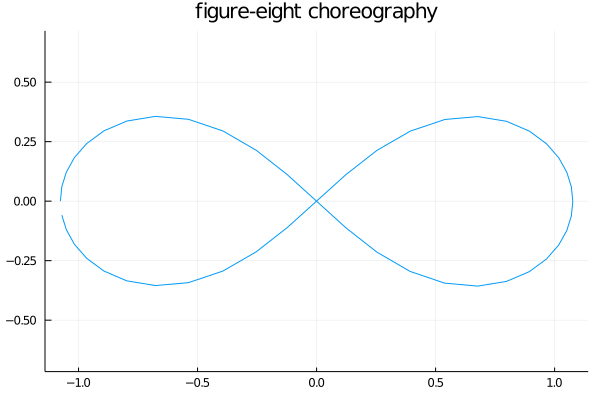

In [33]:
plot(xx_fig8,yy_fig8,aspect_ratio=1, legend=false, title="figure-eight choreography")

In [34]:
k, p = ActionK(xx_fig8, yy_fig8, 2pi), ActionP(xx_fig8, yy_fig8, 2pi)
act = Action(xx_fig8,yy_fig8, 2pi)

println("Kintetic: ", k)
println("Potential: ", p)
println("K+P: ", k+p)
println("Action: ", act)

Kintetic: 1.2929761267895283
Potential: 2.5859522535790562
K+P: 3.878928380368585
Action: 3.8789283803685835


### Action of a curve with the same code
Now we will generate a curve with the same relative code as the figure eight, $\langle 3, 1 \rangle$

In [35]:
s = [3, 1]
T = 2pi
qq, tt = generate_choreography(s, T, N);
xx0, yy0 = qq[1], qq[4];

Rescale the curve

In [36]:
k, p = ActionK(xx0, yy0, T), ActionP(xx0, yy0, T)
nu = cbrt(p/2k)
xx0 *= nu
yy0  *= nu;

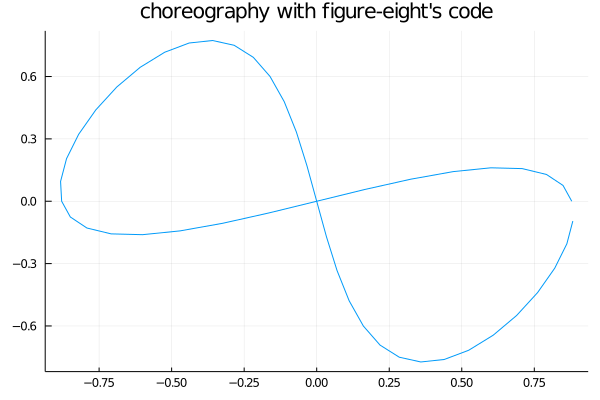

In [37]:
plot(xx0, yy0, legend=false, title="choreography with figure-eight's code")

In [38]:
k, p = ActionK(xx0, yy0, 2pi), ActionP(xx0, yy0, 2pi)
act = Action(xx0, yy0, 2pi)

println("Kintetic: ", k)
println("Potential: ", p)
println("K+P: ", k+p)
println("Action: ", act)

Kintetic: 1.352339111006338
Potential: 2.7046782220126757
K+P: 4.057017333019013
Action: 4.057017333019013


It is necessary to ensure that the solutions with $\nabla A = 0$ are isolated, in other words, their Hessian matrix cannot be singular. To achieve this we will assume (without loss of generalization) that all three bodies are initially aligned on the $x$ axis:
$$
y_{M}= y_{2M}= y_{3M} = 0.
$$

In total, there will be $6M-2$ variables to minimize: $3M$ on the $x$ axis, $3M-3$ on the $y$ axis, and $\omega>0$ (or alternatively $T=2\pi/\omega$).

Aditionally, in order to decrease the dimensionality of the problem we can assume the following for indices $j=1,\ldots,M$:

$$
x_{j+2M} = -x_{j} -x_{j+M}, \quad y_{j+2M} = -y_{j} -y_{j+M}, (2)
$$

and

$$
\dot x_{j+2M} = -\dot x_{j} -\dot x_{j+M}, \quad \dot y_{j+2M} = -\dot y_{j} -\dot y_{j+M}.
$$

Our curve generator already satisfies the constraints:

In [39]:
M = div(length(yy0),3)
println(yy0[1])
println(yy0[M+1])
println(yy0[2M+1])

0.0
0.0
0.0


Define `val2xy` that takes a vector `val` with the properties just described above and returns the list of the $x$ and $y$ coordinates of all points on the curve.

In [40]:
function val2xy(val)
    M = div(length(val)+2,4)
    xx = Array{Float64}(undef,3M)
    yy = Array{Float64}(undef,3M)
    xx[1:2M] .= val[1:2M]
    yy[1] = 0
    yy[2:M] .= val[2M+1:3M-1]
    yy[M+1] = 0
    yy[M+2:2M] .= val[3M:4M-2]
    @. xx[2M+1:3M] = -xx[1:M] - xx[M+1:2M]  
    @. yy[2M+1:3M] = -yy[1:M] - yy[M+1:2M]  
    yy[1] = 0
    yy[M+1] = 0
    yy[2M+1] = 0
    return xx, yy
end

function xy2val(xx,yy)
    M = div(length(xx),3)
    @assert yy[1]==0 && yy[M+1]==0 && yy[2M+1]==0
    val = Array{Float64}(undef,4M-2)
    val[1:2M] .= xx[1:2M]
    val[2M+1:3M-1] .= yy[2:M]
    val[3M:4M-2] .= yy[M+2:2M]
    return val
end

xy2val (generic function with 1 method)

Define the objective function for the minimization of the action.

In [41]:
function FourierEvenD(ff)
    N = length(ff)
    hf = rfft(ff)
    M = length(hf)-1
    @. hf = im*(0:M) * hf
    hf[M+1] /= 2
    return real.(irfft(hf,N))
end

FourierEvenD (generic function with 1 method)

In [42]:
N = length(xx_fig8)
norm(DiffMatrix(N)*xx_fig8 - FourierEvenD(xx_fig8))

2.7543939618718138e-14

In [43]:
function objective(val)
    xx, yy = val2xy(val)
    N = length(xx)
    N3 = div(N,3)
    N23 = 2*N3
    
    vx = FourierEvenD(xx)
    vy = FourierEvenD(yy)
    
    summ = 0.0
    for i in 1:N
        vxi = vx[i]
        vyi = vy[i]
        summ += vxi*vxi + vyi * vyi
    end
    summ *= 0.5
    for i in 1:N3
        xjk = xx[i]-xx[i+N3] 
        yjk = yy[i]-yy[i+N3] 
        summ += (xjk*xjk + yjk*yjk)^-0.5 
        xjk = xx[i+N3]-xx[i+N23] 
        yjk = yy[i+N3]-yy[i+N23] 
        summ += (xjk*xjk + yjk*yjk)^-0.5 
        xjk = xx[i+N23]-xx[i] 
        yjk = yy[i+N23]-yy[i] 
        summ += (xjk*xjk + yjk*yjk)^-0.5 
    end
    return 3*summ/N
end

objective (generic function with 1 method)

### Minimizing the action of the newly generated curve

In [50]:
val0 = xy2val(xx0,yy0)
(objective(val0))

4.057017333019013

In [51]:
@time result = optimize(objective, val0, NelderMead(), 
                  Optim.Options(g_tol = 1e-8, iterations = 1000000))

 22.835422 seconds (23.28 M allocations: 2.030 GiB, 4.52% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     3.878913e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    104272
    f(x) calls:    113404


This is the result

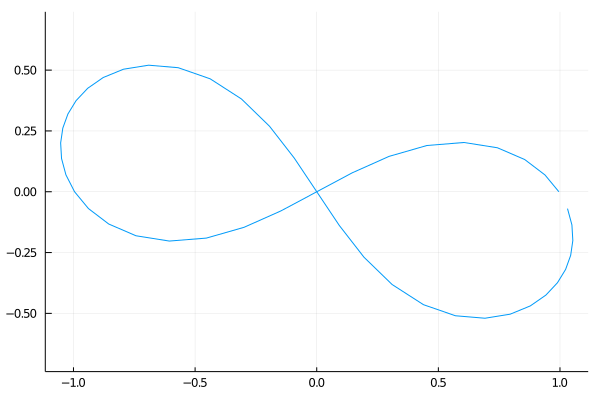

In [55]:
xx_min, yy_min = val2xy(result.minimizer)
plot(xx_min, yy_min, aspect_ratio=1, legend=false)

We can check that the action of the minimized curve is lower than the initial one. In fact, it is equal to that of the figure-eight.

In [56]:
println("Action of the initial curve: ", Action(xx0, yy0))
println("Action of the minimized curve: ", Action(xx_min, yy_min))
println("Action of the figure-eight: ", Action(xx_fig8,yy_fig8))

Action of the initial curve: 4.057017333019013
Action of the minimized curve: 3.8789126685679687
Action of the figure-eight: 3.8789283803685835


These results are no coincidence, if we rotate our result by $\theta \approx 0.24$ we can see that both the figure-eight and the minimized curve are identical.

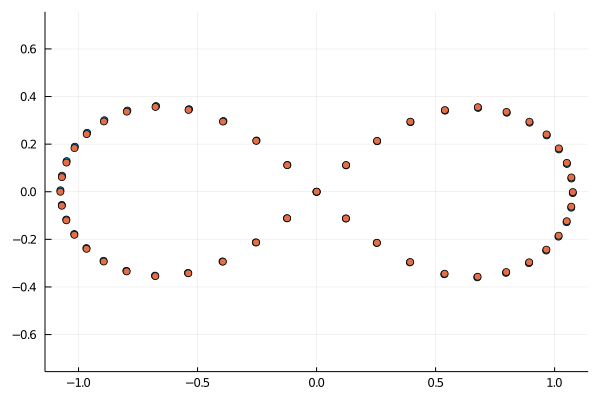

In [57]:
theta = 0.24
zz = exp(im*theta)*(xx_min + im*yy_min)
plot(aspect_ratio=1, legend=false)
scatter!(real.(zz), imag.(zz))
scatter!(xx_fig8, yy_fig8)